<a href="https://colab.research.google.com/github/RaziehSh1987/3D-landmarks-Pose_estimation/blob/main/BlazePose3D_Using_2D_Keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To generate the 2D keypoints, I'll provide an example using Detectron2. First, you need to install Detectron2 and its dependencies:

Install Detectron2:

In [ ]:
# BlazePose3D_Using_2D_Keypoints
import torch

if torch.cuda.is_available():
    print("GPU is being used.")
else:
    print("CPU is being used.")


print(torch.__version__, torch.cuda.is_available())


GPU is being used.
2.0.0+cu118 True


In [ ]:
# check CUDA version
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


* Cython is a programming language that is a superset of Python and allows for writing Python code that can be compiled to C or C++ for improved performance. It is used for speeding up Python code by making it run at C-like speeds while still retaining the ease-of-use and dynamic nature of Python.

* 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' is a command that installs the COCO API package for Python using pip.

COCO (Common Objects in Context) is a large-scale object detection, segmentation, and captioning dataset. The COCO API provides a Python interface for accessing the dataset and working with its annotations, as well as tools for evaluating object detection and segmentation models on the dataset.

In [ ]:
!pip install -U torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
!pip install -U cython
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git@v0.6'






Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-pl_frhc1
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-pl_frhc1
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397991 sha256=c7cafadbc7f38464b4202039c35e0f9ff5b2e4644a0e3804d1d62c41ce3c96b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ev0xdrju/wheels/13/c1/d6/a321055f7089f1a6af654fbf7945

* Detectron is an open-source deep learning framework for object detection and segmentation tasks developed by Facebook AI Research (FAIR). It is built on top of the PyTorch deep learning framework and provides a flexible and modular implementation of state-of-the-art object detection algorithms.

Detectron supports a wide range of object detection and segmentation models, including Faster R-CNN, Mask R-CNN, RetinaNet, and DensePose. It also provides pre-trained models for various tasks, such as instance segmentation, keypoint detection, and panoptic segmentation.

Detectron has become a popular tool in the computer vision research community and has been used in a variety of applications, including autonomous driving, robotics, and medical imaging.

* setup_logger() is a function that initializes the logging system used by Detectron2. It sets the logging level, format, and destination of the log messages, and returns a logger object that can be used to log messages throughout the code.
In the context of logging, the logging level refers to the severity of the messages that are logged. There are several logging levels available, including DEBUG, INFO, WARNING, ERROR, and CRITICAL, each indicating a different level of severity.

Setting the logging level to INFO means that all log messages of severity INFO and higher (WARNING, ERROR, and CRITICAL) will be logged, while messages of lower severity (DEBUG) will be ignored.

In other words, setting the logging level to INFO will result in a moderate amount of log messages being generated, providing useful information about the program's execution without overwhelming the user with too much detail.

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


<Logger detectron2 (DEBUG)>

In [ ]:
## uninstall the pytorch
# !pip uninstall -y detectron2 torch torchvision


# !apt-get install -y python3.7-dev

# install Detectron
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html  #-----------

## Restart the Colab runtime:
# import os
# os.kill(os.getpid(), 9)




Extract the frames from the video:

In [ ]:
# %cd ..

!rm -r frames
# %pwd

In [ ]:
import cv2
import os

video_path = "/content/drive/MyDrive/BishopThesisv9-Medapipe-unity/input/004.mp4"
frames_directory = "frames"

if not os.path.exists(frames_directory):
    os.makedirs(frames_directory)

cap = cv2.VideoCapture(video_path)
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break

    frame_path = os.path.join(frames_directory, f"frame{frame_idx:04d}.png") #define a path+name for each frame
    cv2.imwrite(frame_path, frame)  #save extraceted inage into frame
    frame_idx += 1

cap.release()

**Generate the 2D keypoints using Detectron2 and save them as a .npy file:
*** After completing these steps, you'll have the 2D keypoints saved in a .npy file named "keypoints.npy". You can then proceed to run the VideoPose3D model and predict the 3D landmarks.

In [ ]:
import numpy as np
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

frames = sorted(os.listdir(frames_directory))

keypoints_list = []

for frame_name in frames:
    frame_path = os.path.join(frames_directory, frame_name)
    im = cv2.imread(frame_path)
    outputs = predictor(im)

    if len(outputs["instances"]) > 0:
        keypoints = outputs["instances"].to("cpu").get_fields()["pred_keypoints"][0].numpy()
        keypoints_list.append(keypoints[:, :2])
    else:
        keypoints_list.append([])

np.save("/content/drive/MyDrive/BishopThesisv10-3dLandmark-unity/BlazePose_input_output/2D_Output/keypoints4.npy", keypoints_list)

model_final_a6e10b.pkl: 237MB [00:01, 147MB/s]                           
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


----------------------------Create 3D Landmarks_Blaze_Poze----------------------------------


```
Here's a high-level overview of the steps:

Install MediaPipe and other dependencies required for running BlazePose on Google Colab.

Load the 2D keypoints for each of the four videos. we used of Detectron2 to read the video frames and extract the 2D keypoints using BlazePose.

Apply BlazePose to the 2D keypoints to obtain the 3D landmarks. You can use the pre-trained BlazePose model provided by Google, or train your own model if required.

Save the 3D landmarks for each frame of each video as a separate text file in the specified format.
```



In [ ]:
!pip install mediapipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 18.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
frame_idx=0
# Load the 2D keypoints from the saved file
keypoints_2d = np.load("/content/drive/MyDrive/BishopThesisv10-3dLandmark-unity/BlazePose_input_output/2D_Output/keypoints4.npy")

# Create a MediaPipe BlazePose model
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose_model:

    # Initialize an empty list to store the 3D landmarks
    landmarks_3d = []

    max_num_keypoints = 17

    # Loop through each frame of the video
    for keypoints in keypoints_2d:
      # print(keypoints)#[[453.30832   71.24796 ]..]
    # Extract the 3D landmarks from the 2D keypoints
      input_keypoints = np.expand_dims(keypoints, axis=0)
      # print(keypoints.shape,input_keypoints.shape)#(17, 2) (1, 17, 2)
      num_keypoints = input_keypoints.shape[1] #17
     
      # # if num_keypoints < 24:
      # #     input_keypoints = np.pad(input_keypoints, ((0,0),(0,24-num_keypoints),(0,0)), mode='constant') # Add zeros for the missing keypoints
      
      # # Pad the input_keypoints array with zeros to the maximum length
      if num_keypoints < max_num_keypoints:
          input_keypoints = np.pad(input_keypoints, ((0,0),(0,max_num_keypoints-num_keypoints),(0,0)), mode='constant') # Add zeros for the missing keypoints
      elif num_keypoints > max_num_keypoints:
          max_num_keypoints = num_keypoints
          input_keypoints = np.pad(input_keypoints, ((0,0),(0,max_num_keypoints-num_keypoints),(0,0)), mode='constant') # Add zeros for the missing keypoints
            
      input_keypoints = np.transpose(input_keypoints, (0,2,1)) # Swap the second and third axes
      print(input_keypoints)#[0][0][:])
      
      # try:
      # Load the image
      frame_name = f"frame{frame_idx:04d}.png"# "{:04d}.jpg".format(frame_idx)
      frame_path = os.path.join(frames_directory, frame_name)
      im = cv2.imread(frame_path)
      # print(frame_name)#frame0056.png
      # print(im.shape)#(466, 952, 3)

      # Convert the image to RGB if needed
      if im.shape[2] != 3:
          im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

      # Run the BlazePose model on the image and the 2D keypoints
      results = pose_model.process(image=im)#, landmarks=input_keypoints[0][0][:])

      # Extract the 3D landmarks from the results
      landmarks = []
      if results.pose_landmarks:
          for landmark in results.pose_landmarks.landmark:
              landmarks.append((landmark.x, landmark.y, landmark.z))  #0.48833927512168884 0.12189597636461258 -0.004090915899723768
            
      else:
          landmarks = [(-1, -1, -1)] * 33 # * num_keypoints 

      print(np.array(landmarks))
      
      # Add the 3D landmarks to the list
      landmarks_3d.append(np.array(landmarks))

       
      # except TypeError as e:
      #   print(f"Error: {e}")

      frame_idx += 1
# # Calculate the maximum number of keypoints
# max_num_keypoints = max([len(l) for l in landmarks_3d])

# ## Save the 3D landmarks to a text file
# # np.savetxt('/content/drive/MyDrive/BishopThesisv10-3dLandmark-unity/BlazePose_input_output/3d_output_txt/3d_landmarks_2.txt', np.array(landmarks_3d).reshape(-1, max_num_keypoints*3), fmt='%.6f')#to save whitout []
# ##np.savetxt('/content/drive/MyDrive/BishopThesisv10-3dLandmark-unity/BlazePose_input_output/3d_output_txt/3d_landmarks_2.txt', np.array(landmarks_3d))#incorrect

# filename = '/content/drive/MyDrive/BishopThesisv10-3dLandmark-unity/BlazePose_input_output/3d_output_txt/3d_landmarks_22.txt'
# with open(filename, "w") as file:
#     for landmarks in landmarks_3d:
#         file.write("[")
#         for landmark in landmarks:
#             file.write(f"[{landmark[0]} {landmark[1]} {landmark[2]}]\n")
#         file.write("]\n")


Streaming output truncated to the last 5000 lines.
 [ 0.48974237  0.4351539   0.00696851]
 [ 0.50693113  0.43343779  0.0234122 ]
 [ 0.49250063  0.50408655 -0.03466372]
 [ 0.50264585  0.49502465 -0.01353199]
 [ 0.49318871  0.51425552 -0.03874936]
 [ 0.50162256  0.50367099 -0.01672209]
 [ 0.49206531  0.51659077 -0.0518742 ]
 [ 0.5019744   0.51309282 -0.02808261]]
[[[478.5196  481.37183 475.6674  471.38907 484.9371  463.54544 489.21542
   454.27573 497.05905 461.4063  501.33734 469.24988 483.51102 466.39764
   483.51102 467.8238  481.37183]
  [112.98896 110.14248 110.14248 111.56572 112.98896 129.35623 130.06786
   149.28162 150.70485 157.10945 169.20699 167.78375 167.78375 206.21127
   202.65317 243.92715 234.6761 ]]]
[[ 0.50128013  0.23985748  0.06244798]
 [ 0.50022709  0.23405191  0.05236656]
 [ 0.49928999  0.23410431  0.05236984]
 [ 0.49831235  0.23421031  0.05237546]
 [ 0.5029434   0.23420855  0.05289455]
 [ 0.50392425  0.234413    0.05289269]
 [ 0.50500339  0.23467179  0.0528733 ]
 

In [ ]:
print(len(landmarks_3d))
for i in range(0,len(landmarks_3d)):
  print(len(landmarks_3d[i]))
  if len(landmarks_3d[i])!=33:
    print(f'{landmarks_3d[i]}----------------------------')

400
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33


In [ ]:
# save coordinates as a Text file
def save_coordinates(filename, coordinates, landmark_numbers):
    with open(filename, "w") as file:
        for i in range(len(coordinates)):
            # file.write(f"Landmark {landmark_numbers[i]}: ({coordinates[i][0]}, {coordinates[i][1]}, {coordinates[i][2]})\n")
          #  for j in range(0,len(landmark_numbers[i])-1):
           for j in range(0,len(landmark_numbers)):
            #  file.write(f"Landmark [{i},{landmark_numbers[j]}]: {coordinates[i][j]}\n")
             file.write(f"Landmark [{i},{landmark_numbers[j]}]: ({coordinates[i][j][0]}, {coordinates[i][j][1]}, {coordinates[i][j][2]})\n")


filename = '/content/drive/MyDrive/BishopThesisv10-3dLandmark-unity/BlazePose_input_output/3d_output_txt/3d_landmarks_4.txt'
landmark_keys=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14, 15,16, 17,18, 19,20, 21,22, 23, 24, 25,26, 27,28, 29,30, 31, 32]
save_coordinates(filename,landmarks_3d,landmark_keys)


plot 3d Skeleton

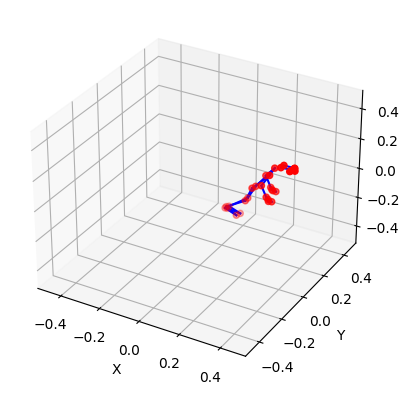

In [ ]:
  # import plotly.graph_objects as go

# # Load the 3D landmarks from the saved file
# # landmarks_3d = np.loadtxt('3d_landmarks.txt')
# landmarks_3d = landmarks_3d
# print(landmarks_3d)

# # Define the skeleton connections
# connections = [
#     [0, 1], [1, 2], [2, 3], [3, 7], [7, 6], [6, 5], [5, 4],
#     [3, 13], [13, 12], [12, 11], [11, 10],
#     [3, 9], [9, 8], [8, 15], [15, 14],
#     [8, 4], [4, 16], [16, 17], [17, 18], [18, 19], [19, 20],
#     [14, 21], [21, 22], [22, 23], [23, 24], [14, 25], [25, 26],
#     [26, 27], [27, 28], [28, 29], [29, 30]
# ]

# # Create an empty 3D plot
# fig = go.Figure()

# # Plot each frame of the animation
# for landmarks in landmarks_3d:
#     # Plot the skeleton connections
#     for connection in connections:
#         start_point = landmarks[connection[0]]
#         end_point = landmarks[connection[1]]
#         fig.add_trace(go.Scatter3d(
#             x=[start_point[0], end_point[0]],
#             y=[start_point[1], end_point[1]],
#             z=[start_point[2], end_point[2]],
#             mode='lines',
#             line=dict(color='blue'),
#             opacity=0.7
#         ))

#     # Add a point for each landmark
#     fig.add_trace(go.Scatter3d(
#         x=landmarks[:,0],
#         y=landmarks[:,1],
#         z=landmarks[:,2],
#         mode='markers',
#         marker=dict(color='red', size=3),
#         opacity=0.7
#     ))

#     # Set the plot limits and labels
#     fig.update_layout(
#         scene=dict(
#             xaxis=dict(range=[-1,1], title='X'),
#             yaxis=dict(range=[-1,1], title='Y'),
#             zaxis=dict(range=[-1,1], title='Z'),
#         )
#     )

#     # Display the plot
#     fig.show()

# ---I have to change this code to plot for all frames and with go library---the below code is correct
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the 3D landmarks from the saved file
# landmarks_3d = np.loadtxt('3d_landmarks.txt')
landmarks_3d =landmarks_3d
# print(landmarks_3d)

# Define the skeleton connections
connections =[[15, 21], [16, 20], [18, 20], [3, 7], [14, 16], [23, 25], [28, 30], [11, 23], [27, 31], [6, 8], [15, 17], [24, 26], [16, 22], [4, 5], [5, 6], [29, 31], [12, 24], [23, 24], [0, 1], [9, 10], [1, 2], [0, 4], [11, 13], [30, 32], [28, 32], [15, 19], [16, 18], [25, 27], [26, 28], [12, 14], [17, 19], [2, 3], [11, 12], [27, 29], [13, 15]]
#  [    [0, 1], [1, 2], [2, 3], [3, 7], [7, 6], [6, 5], [5, 4],
#     [3, 13], [13, 12], [12, 11], [11, 10],
#     [3, 9], [9, 8], [8, 15], [15, 14],
#     [8, 4], [4, 16], [16, 17], [17, 18], [18, 19], [19, 20],
#     [14, 21], [21, 22], [22, 23], [23, 24], [14, 25], [25, 26],
#     [26, 27], [27, 28], [28, 29], [29, 30]
# ]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each frame of the animation
for landmarks in landmarks_3d:
    # Plot the skeleton connections
    for connection in connections:
        start_point = landmarks[connection[0]]
        end_point = landmarks[connection[1]]
        # ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], color='blue')
        ax.plot([-start_point[2], -end_point[2]],[start_point[0], end_point[0]], [-start_point[1], -end_point[1]], color='blue')
    
    # Add a point for each landmark
    # ax.scatter(landmarks[:,0], landmarks[:,1], landmarks[:,2], color='red')
    ax.scatter(-landmarks[:,2], landmarks[:,0],-landmarks[:,1], color='red')

    # Set the plot limits and labels
    # ax.set_xlim(-1, 1)
    # ax.set_ylim(-1, 1)
    # ax.set_zlim(-1, 1)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(-0.5, 0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Display the plot
    plt.show()
